# TTA Predictor on PASCAL VOC dataset

This notebook shows a small example on how to use TTA Predictor to obtain better results on segmentation task. We use [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/) dataset which has **20 classes**. We use code and pretrained weights of [Deeplab v3+](https://github.com/bonlime/keras-deeplab-v3-plus) (Deeplab v3+ reimplemented in Keras). At the end we compare results of the same model with and without augmentations.

### Import dependencies

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# add our package and deeplab directories to the path
import sys
sys.path.append('../')
sys.path.append('deepLab/')

In [3]:
import cv2 
import numpy as np
from model import Deeplabv3
import matplotlib.pyplot as plt
from utils import color_map,multi_iou
%matplotlib inline

Using TensorFlow backend.


### Constants

In [4]:
# Filename to use for comparison (3 sample files are given in 'data' folder)
FILE = '000033' 

# Input size of the deeplab model
IN_SIZE = 500 

### Helper functions

In [5]:
def normalize(img):
    img = img[:,:,[2,1,0]]
    w, h, _ = img.shape
    ratio = IN_SIZE / np.max([w,h])
    resized = cv2.resize(img,(int(ratio*h),int(ratio*w)))
    resized = resized / 127.5 - 1.
    pad_x = int(IN_SIZE - resized.shape[0])
    resized2 = np.pad(resized,((0,pad_x),(0,0),(0,0)),mode='constant')
    return pad_x,np.expand_dims(resized2,0)

In [6]:
def postprocess(pred,pad_x):
    labels = np.argmax(pred.squeeze(),-1)
    return (labels[:-pad_x])

#### Now we make an instance of our object model

In [7]:
deeplab_model = Deeplabv3(weights='pascal_voc',backbone='mobilenetv2',input_shape=(IN_SIZE, IN_SIZE, 3))

#### Load the image and corresponding mask

In [8]:
img = cv2.imread("data/images/%s.jpg"%FILE)
gt = cv2.imread("data/masks/%s.png"%FILE)

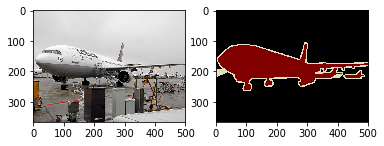

In [9]:
# plot them
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img[:,:,[2,1,0]])
axarr[1].imshow(gt[:,:,[2,1,0]])

In [10]:
# map the RGB value to the corresponding classes
gt = gt[:,:,[2,1,0]]
cmap = color_map()
new_gt = np.zeros(gt.shape[:2],dtype=np.uint8)
for i,c in enumerate(cmap):
    cond = np.logical_and(np.logical_and(gt[:,:,0]==c[0], gt[:,:,1]==c[1]), gt[:,:,2]==c[2])
    new_gt[cond] = i
new_gt[new_gt==255] =0

### Exp1: Predict image without augmentation

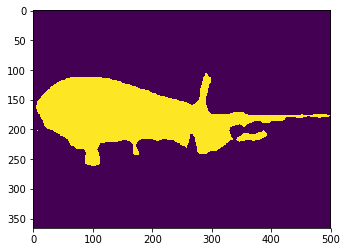

In [11]:
pad_x,normalized = normalize(img)
res = deeplab_model.predict(normalized)
no_aug = postprocess(res,pad_x)
plt.imshow(no_aug)

### Exp2: Using same model with TTA Predictor

#### step 1: import base class `BasePredictor`

In [12]:
from edafa import BasePredictor

#### step 2: Inherit BasePredictor and implement the 3 main virtual functions: preprocess(), postprocess(), predict_patches()

In [13]:
class myPredictor(BasePredictor):
    def __init__(self,model,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.deeplab_model = model
        
    def preprocess(self,img):
        x_pad,norm = normalize(img)
        self.x_pad = x_pad
        return norm

    def postprocess(self,pred):
        return postprocess(pred,self.x_pad)

    def predict_patches(self,patches):
        return self.deeplab_model.predict(patches)

#### step 3: make an instance of your class with the correct parameters

In [14]:
p = myPredictor(deeplab_model,IN_SIZE,21,"../conf/pascal_voc.json")

#### step 4: call predict_dir() with the directories to read images and save predictions
Note that it takes much longer time because it processe all the images in the directory (not only the FILE)

In [15]:
p.predict_dir("data/images/","data/preds/",overlap=0,extension='.png')

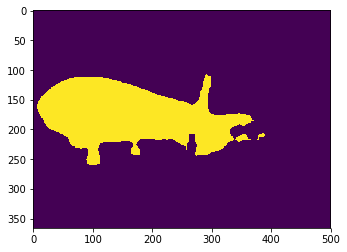

In [16]:
# Visualize the output 
with_aug = cv2.imread("data/preds/%s.png"%FILE,0)
plt.imshow(with_aug)

### Compare results of Exp1 and Exp2

In [17]:
print('IoU with no augmentation: %.6f'%multi_iou(new_gt,no_aug))
print('IoU with augmentation: %.6f'%multi_iou(new_gt,with_aug))

IoU with no augmentation: 0.897766
IoU with augmentation: 0.912922


### Conclusion
Results showed that with the exact same model and by applying TTA Predictor we can obtain better results!